In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import os
import tensorflow as tf

In [11]:
import ijson 

def stratified_stream_json_to_pd_df(sample_size):
    """
      For streaming json rows that has classes that are distributed evenly
    """
    classes_count = [0] * 5 

    with open('yelp_data.json', 'r') as file:
        # parse the JSON objects one by one 
        parser = ijson.items(file, 'item')
        items = []

        for item in parser:
          stars = int(item['stars'])

          # push dictionary into the list for pandas dataframe construction
          if classes_count[stars - 1] < sample_size:
            items.append({ 'text': item['text'], 'stars': int(item['stars']) })
            classes_count[stars - 1] += 1

          if all(j == classes_count[0] for j in classes_count) and classes_count[0] != 0:
             break

    return pd.DataFrame.from_dict(items)

def stream_json_to_pd_df(sample_size):
   """
    For streaming json rows into DataFrame object based on number of rows
   """
   with open('yelp_data.json', 'r') as file:
    parser = ijson.items(file, 'item')
    items = []

    current_sample_size = 0
    for item in parser:
      items.append({ 'text': item['text'], 'stars': int(item['stars']) })
      current_sample_size += 1

      if current_sample_size == sample_size:
        break

    return pd.DataFrame.from_dict(items)


In [3]:
if "preprocessed_data_400000.csv" in os.listdir():
  print("Loading preprocessed data...")
  df = pd.read_csv("preprocessed_data_400000.csv")

else:
  print("Loading raw data...")
  df = stream_json_to_pd_df(400000)

Loading preprocessed data...


In [16]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk import pos_tag

import string
from collections import Counter

def tokenize_string(string):
    return word_tokenize(string)

translate_table = dict((ord(char), None) for char in string.punctuation)
def remove_punctuation(string):
    return string.translate(translate_table)

stopword_list = stopwords.words('english') 
def remove_stopwords(tokens):
    filtered_tokens = []
    for token in tokens:
        if token not in stopword_list:
            filtered_tokens.append(token)

    return filtered_tokens

def remove_duplicates(tokens):
    unique_words = Counter(tokens)
    
    return list(unique_words.keys())

def pos_tagging(tokens):
    """
        Receive: a list of string tokens
        Detect the token's part of speech
    """

    pos_tags = pos_tag(tokens)
    return pos_tags

def lemmatize_token(tokens):
    """
        Tokenize the string
        Lemmatize the string tokens 
        Return lemmatized string
    """
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    pos_tokens = pos_tagging(tokens)

    # convert POS tag into usable format of WordNet
    for token, pos in pos_tokens:
        pos = pos
        if pos.startswith('J'):
            pos = wordnet.ADJ

        elif pos.startswith('V'):
            pos = wordnet.VERB
        
        elif pos.startswith('N'):
            pos = wordnet.NOUN

        elif pos.startswith('R'):
            pos = wordnet.ADV

        else:
            # append as it is if don't have POS tagged
            lemmatized_tokens.append(token)
            continue

        lemmatized = lemmatizer.lemmatize(token, pos=pos)
        lemmatized_tokens.append(lemmatized)

    return lemmatized_tokens

def remove_urls(tokens):
    cleaned_tokens = []
    
    for token in tokens:
        if (not token.startswith('https://')) and (not token.startswith('http://')):
            cleaned_tokens.append(token)

    return cleaned_tokens

def preprocess(string):

    text = remove_punctuation(string.strip().lower())

    tokens = tokenize_string(text)

    tokens = remove_stopwords(tokens)
    
    tokens = remove_duplicates(tokens)

    tokens = remove_urls(tokens)

    tokens = lemmatize_token(tokens)

    return " ".join(tokens)


In [5]:
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# some configurations 
MAX_LENGTH = 128 # maximum number of words from review to use
MAX_FEATURES = 20000 # maximum number of unique words
EMBEDDING_SIZE = MAX_LENGTH # should be the same as MAX_LENGTH
BATCH_SIZE = 512 # number of samples the model see per iteration
EPOCHS = 20 # number of iterations for the model training

# split into features and labels, then perform data partitioning into training and evaluation set 
X = df['text']
y = df['stars']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
sentences = [tokenize_string(corpus) for corpus in X_train] # get sentence tokens 2-D list, format will be [[tokens in 1 corpus], [tokens in another corpus]], used for word2vec embeddings

# Text vectorization using tensorflow Tokenizer, convert the raw text into sequences of token indices
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) # train the tokenizer instance

# transform the raw text into the tokens mentioned
X_train = tokenizer.texts_to_sequences(X_train.astype('str'))
X_test = tokenizer.texts_to_sequences(X_test.astype('str'))

# pad sequences so that all text sequences have the same length
X_train = pad_sequences(X_train, maxlen=MAX_LENGTH)
X_test = pad_sequences(X_test, maxlen=MAX_LENGTH)

# Generate Word Embeddings
w2v_model = Word2Vec(sentences, vector_size=MAX_LENGTH, window=10, min_count=100, workers=4) # for word2vec embeddings
vocab_size = min(MAX_FEATURES, len(tokenizer.word_index.keys()) + 1) # at most 20000 unique words

# create word2vec embedding
embedding_matrix = np.zeros((vocab_size, EMBEDDING_SIZE))
for word, i in tokenizer.word_index.items():
    if i >= MAX_FEATURES:
        break

    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

# apply one-hot encoding to the label
oneHot = LabelBinarizer()
y_train = oneHot.fit_transform(y_train)
y_test = oneHot.transform(y_test)


### With CNN-LSTM-GRU stacks

In [16]:
from tensorflow.keras.layers import Dense, LSTM, GRU, GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate, Embedding, Input, Bidirectional, SpatialDropout1D, Conv1D, MaxPooling1D, BatchNormalization, Input
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf

tf.random.set_seed(42)

input_layer = Input(shape=(MAX_LENGTH, ))
embedding_layer = Embedding(
  MAX_FEATURES,
  EMBEDDING_SIZE,
  weights=[embedding_matrix],
  trainable=True # allow for fine-tuning
)(input_layer)

spatial_dropout_layer = SpatialDropout1D(0.5)(embedding_layer)
cnn1 = Conv1D(
  filters=64,
  kernel_size=2,
  strides=1
)(spatial_dropout_layer)
batch_norm = BatchNormalization()(cnn1)

# lstm stacked
lstm1 = Bidirectional(LSTM(
  units=64,
  dropout=0.1,
  return_sequences=True
))(batch_norm)
gru1 = Bidirectional(GRU(
  units=64,
  dropout=0.1,
  return_sequences=True
))(lstm1)

global_maxpooling = GlobalMaxPooling1D()(gru1)

# Fully connected layer
output = Dense(5, activation='softmax', kernel_regularizer='l2')(global_maxpooling)
model = Model(inputs=input_layer, outputs=output)

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3)
checkpoint = ModelCheckpoint(monitor='val_loss', save_best_only=True, filepath='cnn_yelp_lstm_gru_weights.hdf5')

model.compile(
  loss=CategoricalCrossentropy(),
  optimizer=Adam(learning_rate=0.1),
  metrics=['accuracy']
)

In [18]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 128, 128)          2560000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 128, 128)         0         
 lDropout1D)                                                     
                                                                 
 conv1d_1 (Conv1D)           (None, 127, 64)           16448     
                                                                 
 batch_normalization_1 (Batc  (None, 127, 64)          256       
 hNormalization)                                                 
                                                                 
 bidirectional_2 (Bidirectio  (None, 127, 128)         6604

In [19]:
history = model.fit(
  X_train,
  y_train,
  epochs=EPOCHS,
  validation_split=0.1,
  batch_size=BATCH_SIZE,
  callbacks=[earlystop, checkpoint]
)

Epoch 1/20
563/563 [==============================] - 59s 100ms/step - loss: 1.3229 - accuracy: 0.4908 - val_loss: 1.1119 - val_accuracy: 0.5432
Epoch 2/20
563/563 [==============================] - 55s 97ms/step - loss: 1.1104 - accuracy: 0.5380 - val_loss: 1.1401 - val_accuracy: 0.5323
Epoch 3/20
563/563 [==============================] - 54s 95ms/step - loss: 1.2416 - accuracy: 0.4918 - val_loss: 1.3240 - val_accuracy: 0.5117
Epoch 4/20
563/563 [==============================] - 54s 96ms/step - loss: 1.1817 - accuracy: 0.5087 - val_loss: 1.1483 - val_accuracy: 0.5115


In [20]:
y_pred = model.predict(X_test)

2500/2500 [==============================] - 26s 10ms/step


In [26]:
from sklearn.metrics import classification_report

inversed_transformed_ytest = oneHot.inverse_transform(y_test)
inversed_transformed_ypred = oneHot.inverse_transform(y_pred)

print(
  classification_report(
    inversed_transformed_ytest, 
    inversed_transformed_ypred,
    digits=3, # for floating points
    labels=oneHot.classes_ # the classes labels
  )
)

              precision    recall  f1-score   support

           1      0.598     0.338     0.432      9585
           2      0.000     0.000     0.000      6335
           3      0.220     0.379     0.278      8771
           4      0.315     0.222     0.260     19224
           5      0.654     0.832     0.732     36085

    accuracy                          0.511     80000
   macro avg      0.357     0.354     0.340     80000
weighted avg      0.466     0.511     0.475     80000



c:\Users\Usrer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Usrer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Usrer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [27]:
def calculate_acc_classes(y_pred, y_test):
  labels = [1, 2, 3, 4, 5]
  correct_labels_counts = [0] * 5
  truth_labels_count = np.unique(y_test, return_counts=True)[1]

  for i in range(len(y_test)):
    if y_test[i] == y_pred[i]:
      correct_labels_counts[y_test[i] - 1] += 1

  # calculate accuracy of each label and plot
  accuracy_each_label = np.array(correct_labels_counts) / truth_labels_count
  ax = sns.barplot(x=labels, y=accuracy_each_label)
  ax.bar_label(ax.containers[0])
  plt.title("Accuracy of Each Ratings Score")
  plt.xlabel("Ratings Score")
  plt.ylabel("Accuracy in Decimals")
  plt.show()

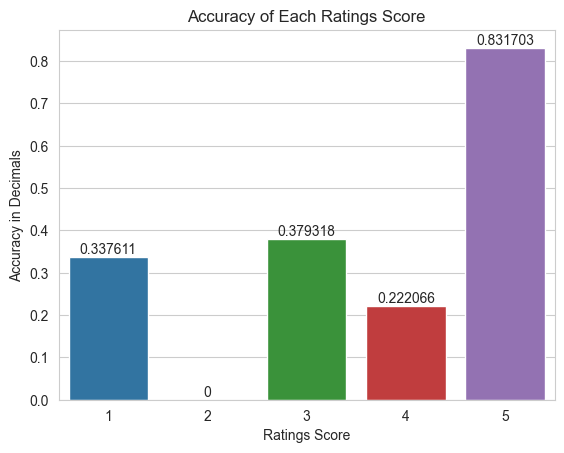

In [28]:
calculate_acc_classes(inversed_transformed_ypred, inversed_transformed_ytest)

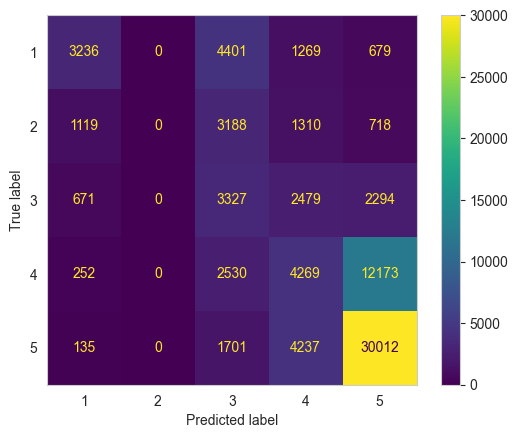

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

matrix = confusion_matrix(inversed_transformed_ytest, inversed_transformed_ypred)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=oneHot.classes_)
disp.plot(values_format='d')
plt.grid(False)
plt.show()

### Hyperparameter Tuning

In [9]:
from tensorflow.keras.layers import Dense, LSTM, GRU, GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate, Embedding, Input, Bidirectional, SpatialDropout1D, Conv1D, MaxPooling1D, BatchNormalization, Input
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
import keras_tuner as kt

tf.random.set_seed(42)

class HyperModel(kt.HyperModel):

  def build(self, hyperparameters):
    input_layer = Input(shape=(MAX_LENGTH, ))
    embedding_layer = Embedding(
      MAX_FEATURES,
      EMBEDDING_SIZE,
      weights=[embedding_matrix],
      trainable=True # allow for fine-tuning
    )(input_layer)

    # hyperparameters
    hp_filters = hyperparameters.Int("filters", min_value=64, max_value=96, step=32)
    hp_units = hyperparameters.Int("units", min_value=64, max_value=96, step=32)
    hp_rates = hyperparameters.Choice('dropout', values=[0.1, 0.2])
    hp_learning_rate = hyperparameters.Choice('learning_rate', values=[0.1, 0.01, 0.001])

    spatial_dropout_layer = SpatialDropout1D(0.5)(embedding_layer)
    cnn1 = Conv1D(
      filters=hp_filters,
      kernel_size=2,
      strides=1
    )(spatial_dropout_layer)
    batch_norm = BatchNormalization()(cnn1)

    # lstm stacked
    lstm1 = Bidirectional(LSTM(
      units=hp_units,
      dropout=hp_rates,
      return_sequences=True
    ))(batch_norm)
    gru1 = Bidirectional(GRU(
      units=hp_units,
      dropout=hp_rates,
      return_sequences=True
    ))(lstm1)

    global_maxpooling = GlobalMaxPooling1D()(gru1)

    # Fully connected layer
    output = Dense(5, activation='softmax', kernel_regularizer='l2')(global_maxpooling)
    model = Model(inputs=input_layer, outputs=output)

    model.compile(
      loss=CategoricalCrossentropy(),
      optimizer=Adam(learning_rate=hp_learning_rate),
      metrics=['accuracy']
    )

    return model
  
  def fit(self, hyperparameters, model, *args, **kwargs):
    return model.fit(
        *args,
        batch_size=hyperparameters.Choice("batch_size", [256, 512]),
        **kwargs,
    )

In [10]:
tuner = kt.GridSearch(
  HyperModel(),
  objective='val_accuracy',
  seed=42, # for reproducibility
  directory='model_tune',
  project_name='tuning_cnnlstm'
)

early = EarlyStopping(
  monitor='val_accuracy',
  patience=3
)

tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[early])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 48 Complete [00h 15m 35s]
val_accuracy: 0.7052249908447266

Best val_accuracy So Far: 0.7062625288963318
Total elapsed time: 07h 20m 08s


In [15]:
print(f"""
Best Hyperparameter List:
      1. CNN Filters - {best_hps.get('filters')}
      2. Hidden Units - {best_hps.get('units')}
      3. Dropout Rate - {best_hps.get('dropout')}
      4. Learning Rate - {best_hps.get('learning_rate')}
      5. Batch Size - {best_hps.get('batch_size')}
""")


Best Hyperparameter List:
      1. CNN Filters - 96
      2. Hidden Units - 96
      3. Dropout Rate - 0.1
      4. Learning Rate - 0.001
      5. Batch Size - 512



### Build with the best hyperparameter set

In [40]:
from tensorflow.keras.layers import Dense, LSTM, GRU, GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate, Embedding, Input, Bidirectional, SpatialDropout1D, Conv1D, MaxPooling1D, BatchNormalization, Input
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf

tf.random.set_seed(42)

input_layer = Input(shape=(MAX_LENGTH, ))
embedding_layer = Embedding(
  MAX_FEATURES,
  EMBEDDING_SIZE,
  weights=[embedding_matrix],
  trainable=True # allow for fine-tuning
)(input_layer)

spatial_dropout_layer = SpatialDropout1D(0.5)(embedding_layer)
cnn1 = Conv1D(
  filters=96,
  kernel_size=2,
  strides=1
)(spatial_dropout_layer)
batch_norm = BatchNormalization()(cnn1)

# lstm stacked
lstm1 = Bidirectional(LSTM(
  units=96,
  dropout=0.1,
  return_sequences=True
))(batch_norm)
gru1 = Bidirectional(GRU(
  units=96,
  dropout=0.1,
  return_sequences=True
))(lstm1)

global_maxpooling = GlobalMaxPooling1D()(gru1)

# Fully connected layer
output = Dense(5, activation='softmax', kernel_regularizer='l2')(global_maxpooling)
model = Model(inputs=input_layer, outputs=output)

earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3)
checkpoint = ModelCheckpoint(monitor='val_accuracy', save_best_only=True, filepath='cnn_yelp_lstm_gru_weights.hdf5')

model.compile(
  loss=CategoricalCrossentropy(),
  optimizer=Adam(learning_rate=0.001),
  metrics=['accuracy']
)

In [41]:
history = model.fit(
  X_train,
  y_train,
  batch_size=512, 
  validation_split=0.1,
  epochs=20,
  callbacks=[earlystop]
)

Epoch 1/20
563/563 [==============================] - 44s 72ms/step - loss: 0.9530 - accuracy: 0.6135 - val_loss: 0.8068 - val_accuracy: 0.6642
Epoch 2/20
563/563 [==============================] - 40s 71ms/step - loss: 0.8301 - accuracy: 0.6515 - val_loss: 0.7679 - val_accuracy: 0.6778
Epoch 3/20
563/563 [==============================] - 40s 71ms/step - loss: 0.7959 - accuracy: 0.6641 - val_loss: 0.7512 - val_accuracy: 0.6833
Epoch 4/20
563/563 [==============================] - 40s 70ms/step - loss: 0.7744 - accuracy: 0.6726 - val_loss: 0.7475 - val_accuracy: 0.6862
Epoch 5/20
563/563 [==============================] - 39s 70ms/step - loss: 0.7591 - accuracy: 0.6790 - val_loss: 0.7344 - val_accuracy: 0.6880
Epoch 6/20
563/563 [==============================] - 40s 70ms/step - loss: 0.7459 - accuracy: 0.6845 - val_loss: 0.7274 - val_accuracy: 0.6931
Epoch 7/20
563/563 [==============================] - 39s 70ms/step - loss: 0.7360 - accuracy: 0.6885 - val_loss: 0.7188 - val_accuracy:

In [42]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
inversed_transformed_ytest = oneHot.inverse_transform(y_test)
inversed_transformed_ypred = oneHot.inverse_transform(y_pred)

print(
  classification_report(
    inversed_transformed_ytest, 
    inversed_transformed_ypred,
    digits=3, # for floating points
    labels=oneHot.classes_ # the classes labels
  )
)

2500/2500 [==============================] - 27s 10ms/step
              precision    recall  f1-score   support

           1      0.738     0.840     0.785      9585
           2      0.471     0.510     0.489      6335
           3      0.552     0.434     0.486      8771
           4      0.613     0.488     0.544     19224
           5      0.792     0.879     0.833     36085

    accuracy                          0.702     80000
   macro avg      0.633     0.630     0.628     80000
weighted avg      0.691     0.702     0.693     80000



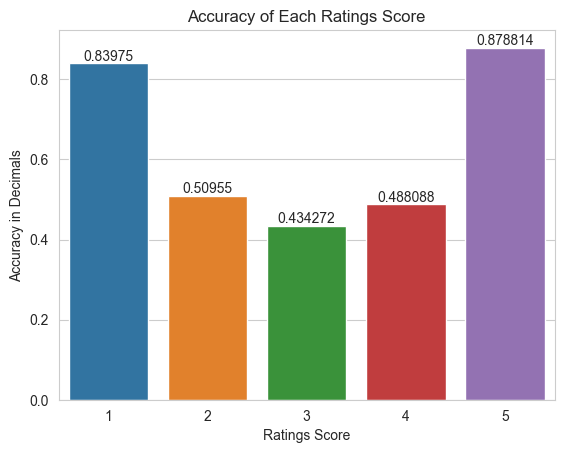

In [43]:
calculate_acc_classes(inversed_transformed_ypred, inversed_transformed_ytest)

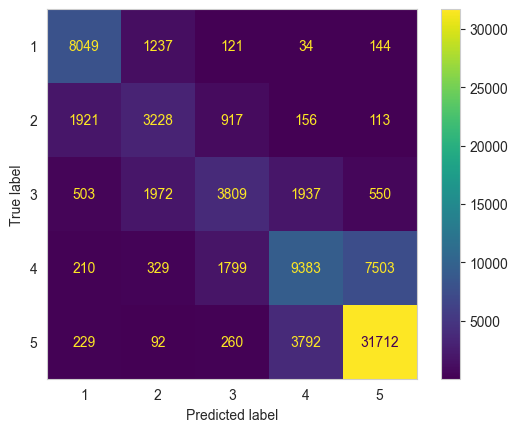

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

matrix = confusion_matrix(inversed_transformed_ytest, inversed_transformed_ypred)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=oneHot.classes_)
disp.plot(values_format='d')
plt.grid(False)
plt.show()

In [52]:
trials = tuner.oracle.get_best_trials(num_trials=48)
hp_list = []
for trial in trials:
  hp_list.append(
    trial.hyperparameters.get_config()['values'] | { 'score': trial.score }
  )

hyperparams_df = pd.DataFrame(hp_list)
hyperparams_df.to_csv("tuning_result.csv", index=False)

In [55]:
hyperparams_df

,filters,units,dropout,learning_rate,batch_size,score
0,96,96,0.1,0.001,512,0.706263
1,64,96,0.1,0.001,512,0.706225
2,96,96,0.1,0.001,256,0.705312
3,64,96,0.2,0.001,512,0.705262
4,96,96,0.2,0.001,512,0.705225
5,96,96,0.2,0.001,256,0.704988
6,64,64,0.1,0.001,512,0.704413
7,64,96,0.2,0.001,256,0.704300
8,96,64,0.1,0.001,256,0.703650
9,96,64,0.1,0.001,512,0.703562
